In [214]:
from src.shared_imports import *

plt.style.use("seaborn-v0_8")

In [215]:
df = pd.read_csv("data/processed/gen_sen_merged.csv")
df = df.drop(['HOUR_x', 'DATE_x'], axis=1)
df["DATE_TIME"] = pd.to_datetime(df["DATE_TIME"])
df["DAY"] = df["DATE_TIME"].dt.date

In [216]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   DATE_TIME            68778 non-null  datetime64[ns]
 1   SOURCE_KEY_x         68778 non-null  object        
 2   DC_POWER             68778 non-null  float64       
 3   AC_POWER             68778 non-null  float64       
 4   DAILY_YIELD          68778 non-null  float64       
 5   TOTAL_YIELD          68778 non-null  float64       
 6   INVERTER_EFF         36827 non-null  float64       
 7   AMBIENT_TEMPERATURE  68774 non-null  float64       
 8   MODULE_TEMPERATURE   68774 non-null  float64       
 9   IRRADIATION          68774 non-null  float64       
 10  DAY                  68778 non-null  object        
dtypes: datetime64[ns](1), float64(8), object(2)
memory usage: 5.8+ MB


我们的建模特征（IRR、温度、DC、AC）几乎没有缺失，只有 4 条数据缺值，这些缺失不会对模型训练产生影响，这里使用前向填充处理。
INVERTER_EFF 大量 NaN 是因为 DC_POWER = 0 时除零导致，该指标并不作为模型输入，因此无需清洗也不会影响模型训练。

## 2.1 Baseline DC Power Model

我们用一个简单的线性模型来估计组件在正常情况下应产生的 DC 功率：

DC_POWER = a * IRR + b * MODULE TEMPERATURE + c + ε

原因很简单：
- 光照越强 → DC 输出越高（正相关）
- 温度越高 → 组件效率下降 → DC 输出略下降（负相关）

因此 IRR + 温度 已能很好描述 DC 的物理变化趋势。  
模型中的常数项 c 表示系统性的固定偏移（安装差异、传感器偏移等），
noise ε 表示短期随机波动。

**我们使用线性模型不是因为机器学习不够强，而是因为 PV 的物理过程可以被准确地线性描述。线性模型具备可解释、稳定、鲁棒、可部署、可审计等优势，是光伏行业构建 baseline 和进行故障检测的标准方法。

In [217]:
df_copy = df.copy()
df_copy['DATE_TIME']= pd.to_datetime(df_copy['DATE_TIME'],format='%d-%m-%Y %H:%M')

<Figure size 1500x500 with 0 Axes>

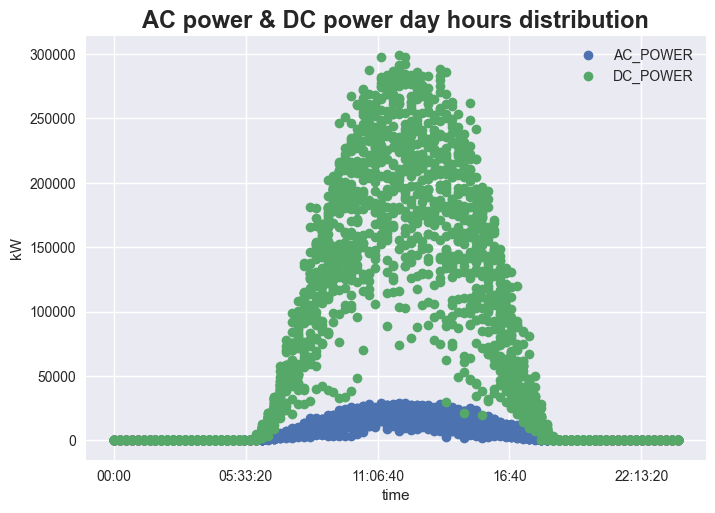

In [218]:
df_copy = df_copy.groupby("DATE_TIME")[['AC_POWER','DC_POWER']].sum().reset_index()
df_copy['time']=df_copy['DATE_TIME'].dt.time
plt.figure(figsize=(15,5))
df_copy.set_index('time')[['AC_POWER','DC_POWER']].plot(style='o')

plt.title("AC power & DC power day hours distribution",fontsize=17,weight="bold")
plt.xlabel("time")
plt.ylabel("kW")
plt.grid(True)

我们可以看到夜间有大量的0数据点，这些0数据会影响回归所以在训练模型时去掉。少量的缺失数据用向前插值的方式进行

### 全局 DC Baseline 回归模型

In [219]:
df = df.sort_values(["DATE_TIME"])
df["AMBIENT_TEMPERATURE"] = df["AMBIENT_TEMPERATURE"].fillna(method="ffill")
df["MODULE_TEMPERATURE"] = df["MODULE_TEMPERATURE"].fillna(method="ffill")
df["IRRADIATION"] = df["IRRADIATION"].fillna(method="ffill")

(df["AMBIENT_TEMPERATURE"] == 0).sum()

C:\Users\pearl\AppData\Local\Temp\ipykernel_22360\2230140758.py:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["AMBIENT_TEMPERATURE"] = df["AMBIENT_TEMPERATURE"].fillna(method="ffill")
C:\Users\pearl\AppData\Local\Temp\ipykernel_22360\2230140758.py:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["MODULE_TEMPERATURE"] = df["MODULE_TEMPERATURE"].fillna(method="ffill")
C:\Users\pearl\AppData\Local\Temp\ipykernel_22360\2230140758.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df["IRRADIATION"] = df["IRRADIATION"].fillna(method="ffill")


np.int64(0)

In [220]:
zero_m = (df["MODULE_TEMPERATURE"] == 0).sum()
zero_I = (df["IRRADIATION"] == 0).sum()
zero_D = (df["DC_POWER"] == 0).sum()

In [221]:
k = (df["IRRADIATION"]>0.1).sum()
print(k)

30722


In [222]:
print(zero_m,zero_I,zero_D)

0 30398 31951


In [223]:
df["DC_POWER"] = df["DC_POWER"] / 1000
df["IRRADIATION"] = df["IRRADIATION"] * 1000

irr_thr = df["IRRADIATION"].max() * 0.15
dc_thr = df["DC_POWER"].max() * 0.05

df_model = df[(df["IRRADIATION"] > irr_thr) &
              (df["DC_POWER"] > dc_thr) &
              (df["MODULE_TEMPERATURE"] > 10)]

X = df_model[["IRRADIATION", "MODULE_TEMPERATURE"]]
y = df_model["DC_POWER"]

model = LinearRegression().fit(X, y)

a, b = model.coef_
c = model.intercept_

print("=== Physical DC Baseline Model ===")
print("a (光照系数) =", a)
print("b (温度系数) =", b)
print("c (偏置) =", c)

df["DC_BASELINE"] = model.predict(df[["IRRADIATION", "MODULE_TEMPERATURE"]])


=== Physical DC Baseline Model ===
a (光照系数) = 0.012403439171303435
b (温度系数) = -0.0014594804273644294
c (偏置) = 0.7118102489836273


In [224]:
df.head()

,DATE_TIME,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,INVERTER_EFF,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DAY,DC_BASELINE
0,2020-05-15,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,NaN,25.184316,22.857507,0.0,2020-05-15,0.67845
20,2020-05-15,zVJPv84UY57bAof,0.0,0.0,0.0,7116151.0,NaN,25.184316,22.857507,0.0,2020-05-15,0.67845
19,2020-05-15,zBIq5rxdHJRwDNY,0.0,0.0,0.0,6339380.0,NaN,25.184316,22.857507,0.0,2020-05-15,0.67845
18,2020-05-15,z9Y9gH1T5YWrNuG,0.0,0.0,0.0,7007866.0,NaN,25.184316,22.857507,0.0,2020-05-15,0.67845
17,2020-05-15,wCURE6d3bPkepu2,0.0,0.0,0.0,6782598.0,NaN,25.184316,22.857507,0.0,2020-05-15,0.67845
